In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [3]:
# -------------------------
# 1️⃣ 掛載 Google Drive
# -------------------------
from google.colab import drive
drive.mount('/content/drive')

# -------------------------
# 2️⃣ 指定 JSONL 路徑
# -------------------------
import os
from datasets import load_dataset

jsonl_path = "/content/drive/MyDrive/dataset.jsonl"  # ✅ 改這裡成你的實際路徑

# 檢查檔案是否存在
assert os.path.exists(jsonl_path), f"❌ 找不到檔案：{jsonl_path}"

# -------------------------
# 3️⃣ 載入資料集
# -------------------------
ds = load_dataset("json", data_files=jsonl_path, split="train")

# -------------------------
# 4️⃣ 統一欄位名稱 sentence / label
# -------------------------
def unify(example):
    # sentence 欄位名稱統一
    sentence = (
        example.get("sentence")
        or example.get("prompt")
        or example.get("text")
        or ""
    )

    # label 欄位名稱統一
    if "completion" in example and example["completion"] is not None:
        label = int(example["completion"])
    elif "level" in example and example["level"] is not None:
        label = int(example["level"])
    else:
        # 若資料沒有 label，可設為 -1 以便過濾
        label = -1

    return {"sentence": sentence, "label": label}

ds = ds.map(unify)

# 過濾掉 label 無效的資料
ds = ds.filter(lambda x: x["label"] != -1)

# -------------------------
# 5️⃣ 檢查結果
# -------------------------
print("✅ 成功載入 dataset.jsonl")
print("📊 總筆數:", len(ds))
print("📝 範例資料：")
print(ds[0])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Filter:   0%|          | 0/165 [00:00<?, ? examples/s]

✅ 成功載入 dataset.jsonl
📊 總筆數: 165
📝 範例資料：
{'prompt': '這句話的討人厭程度 (1-5)：好像還行吧。', 'completion': '1', 'sentence': '這句話的討人厭程度 (1-5)：好像還行吧。', 'label': 1}


In [4]:
# 移除無效或缺 label 筆
ds = ds.filter(lambda x: x["sentence"] is not None and x["sentence"].strip() != "" and x["label"] is not None)

# 轉 label 範圍到 0..4（若原本就是 1..5 ）
def normalize_label(x):
    if x["label"] > 5:  # 保險檢查
        x["label"] = 5
    if x["label"] < 1:
        x["label"] = 1
    x["label"] = int(x["label"]) - 1
    return x

ds = ds.map(normalize_label)

# 切 train / val（80/20）
ds = ds.train_test_split(test_size=0.2, seed=42)
print("train:", len(ds["train"]), "val:", len(ds["test"]))


# 確認 label 範圍
for split in ['train', 'test']:
    labels = [x['label'] for x in ds[split]]
    print(split, "min:", min(labels), "max:", max(labels))

Filter:   0%|          | 0/165 [00:00<?, ? examples/s]

Map:   0%|          | 0/165 [00:00<?, ? examples/s]

train: 132 val: 33
train min: 0 max: 4
test min: 0 max: 4


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "hfl/chinese-roberta-wwm-ext"
num_labels = 5

# 1️⃣ 載入 tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 2️⃣ 新增 pad token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# 3️⃣ 載入模型
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# 4️⃣ 讓模型 embedding 對應新 pad token
model.resize_token_embeddings(len(tokenizer))

# 5️⃣ 設定 pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# 6️⃣ 設定 device 關掉
#device = "cuda" if torch.cuda.is_available() else "cpu"
#model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
max_len = 128
def tok_fn(batch):
    return tokenizer(batch["prompt"], truncation=True, padding="max_length", max_length=max_len)

ds_encoded = ds.map(lambda x: tok_fn(x), batched=True)
ds_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/132 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

In [7]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "value"]  # encoder-based 可試 ["dense"] 或 ["dense_1"]
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 298,757 || all params: 102,570,250 || trainable%: 0.2913


In [8]:
#for n, p in model.named_parameters():
    #print(n, p.dtype)


In [26]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

training_args = TrainingArguments(
    output_dir="./lora_model",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    learning_rate=5e-4,
    logging_strategy="epoch",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    fp16=False,
    report_to="none"
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-371398313.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [27]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision,Recall
1,0.192600,0.747929,0.696970,0.666135,0.703968,0.660952
2,0.195900,0.866948,0.666667,0.638663,0.686111,0.632381
3,0.148400,0.895512,0.727273,0.701300,0.744444,0.700952
4,0.155800,0.898174,0.696970,0.666135,0.703968,0.660952
5,0.112100,0.898606,0.696970,0.666135,0.703968,0.660952
6,0.110300,0.918645,0.696970,0.666135,0.703968,0.660952
7,0.108600,1.002162,0.727273,0.701300,0.744444,0.700952
8,0.185700,1.022308,0.727273,0.701300,0.744444,0.700952
9,0.146200,1.011950,0.696970,0.666135,0.703968,0.660952
10,0.151800,1.003619,0.696970,0.666135,0.703968,0.660952


TrainOutput(global_step=330, training_loss=0.15074450463959665, metrics={'train_runtime': 22.0198, 'train_samples_per_second': 59.946, 'train_steps_per_second': 14.987, 'total_flos': 87131854909440.0, 'train_loss': 0.15074450463959665, 'epoch': 10.0})

In [28]:
# 儲存 PEFT adapter
model.save_pretrained("./lora_model_adapter")
tokenizer.save_pretrained("./lora_model_adapter")


('./lora_model_adapter/tokenizer_config.json',
 './lora_model_adapter/special_tokens_map.json',
 './lora_model_adapter/vocab.txt',
 './lora_model_adapter/added_tokens.json',
 './lora_model_adapter/tokenizer.json')

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
import torch

base_model_name = "hfl/chinese-roberta-wwm-ext"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=5)

# 載入 LoRA adapter
model = PeftModel.from_pretrained(base_model, "./lora_model_adapter")

# 推論函數
def predict_sentence(sent):
    inputs = tokenizer(sent, return_tensors="pt", truncation=True, padding=True, max_length=128).to(model.device)
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = torch.argmax(logits, dim=-1).item()
    return pred + 1

print(predict_sentence("你又拿我筆？"))
print(predict_sentence("哇，你真會把事情弄得這麼亂！"))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2
3


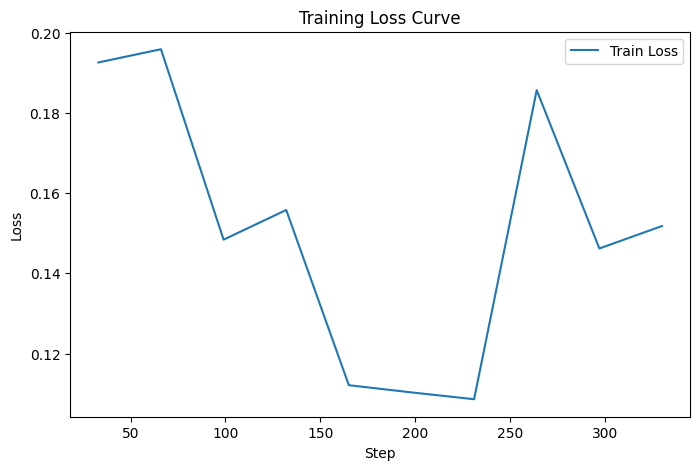

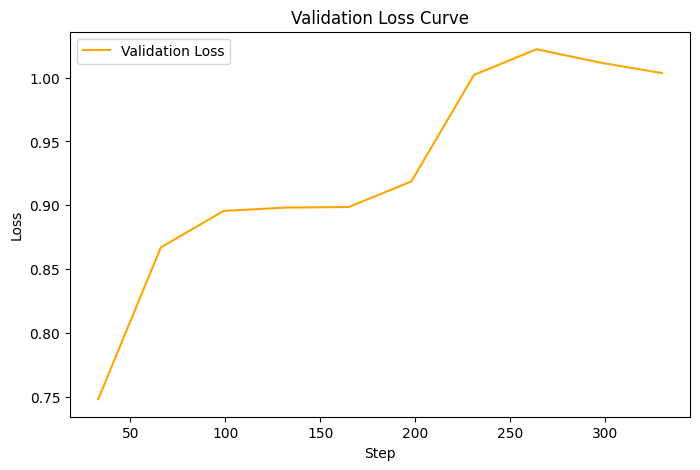

In [30]:
import matplotlib.pyplot as plt

# 取 log_history
logs = trainer.state.log_history

# 取 step 對應 loss
train_logs = [x for x in logs if "loss" in x]

steps = [x["step"] for x in train_logs]
losses = [x["loss"] for x in train_logs]

plt.figure(figsize=(8,5))
plt.plot(steps, losses, label="Train Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

# 如果你也想畫驗證 loss
eval_logs = [x for x in logs if "eval_loss" in x]
if eval_logs:
    eval_steps = [x["step"] for x in eval_logs]
    eval_losses = [x["eval_loss"] for x in eval_logs]
    plt.figure(figsize=(8,5))
    plt.plot(eval_steps, eval_losses, label="Validation Loss", color="orange")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Validation Loss Curve")
    plt.legend()
    plt.show()


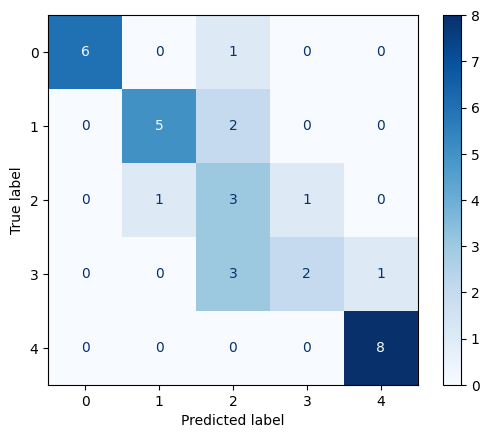

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

model.eval()
all_labels, all_preds = [], []

for batch in ds_encoded["test"]:
    inputs = {k: v.unsqueeze(0) for k, v in batch.items() if k in ["input_ids","attention_mask"]}
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = torch.argmax(logits, dim=-1).item()
    all_preds.append(pred)
    all_labels.append(batch["label"].item())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [32]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, digits=4))


              precision    recall  f1-score   support

           0     1.0000    0.8571    0.9231         7
           1     0.8333    0.7143    0.7692         7
           2     0.3333    0.6000    0.4286         5
           3     0.6667    0.3333    0.4444         6
           4     0.8889    1.0000    0.9412         8

    accuracy                         0.7273        33
   macro avg     0.7444    0.7010    0.7013        33
weighted avg     0.7761    0.7273    0.7329        33



In [33]:
import random
for i in random.sample(range(len(ds_encoded["test"])), 10):
    text = tokenizer.decode(ds_encoded["test"][i]["input_ids"], skip_special_tokens=True)
    true_label = ds_encoded["test"][i]["label"].item()
    pred_label = all_preds[i]
    print(f"Text: {text}")
    print(f"True: {true_label}, Pred: {pred_label}")
    print("-"*40)


Text: 這 句 話 的 討 人 厭 程 度 ( 1 - 5 ) ： 你 打 掃 的 時 候 灰 塵 好 像 更 自 在
True: 3, Pred: 3
----------------------------------------
Text: 這 句 話 的 討 人 厭 程 度 ( 1 - 5 ) ： 你 貢 獻 的 沉 默 比 你 的 話 還 有 價 值 。
True: 4, Pred: 4
----------------------------------------
Text: 這 句 話 的 討 人 厭 程 度 ( 1 - 5 ) ： 原 來 你 也 在 啊 ， 我 還 以 為 沒 來 。
True: 0, Pred: 2
----------------------------------------
Text: 這 句 話 的 討 人 厭 程 度 ( 1 - 5 ) ： 你 的 努 力 唯 一 的 成 果 就 是 笑 話 。
True: 4, Pred: 4
----------------------------------------
Text: 這 句 話 的 討 人 厭 程 度 ( 1 - 5 ) ： 你 這 種 做 法 白 痴 到 我 都 不 想 理 你 。
True: 1, Pred: 1
----------------------------------------
Text: 這 句 話 的 討 人 厭 程 度 ( 1 - 5 ) ： 你 一 加 入 進 度 立 刻 變 成 永 遠 的 草 稿
True: 3, Pred: 4
----------------------------------------
Text: 這 句 話 的 討 人 厭 程 度 ( 1 - 5 ) ： 你 的 陪 伴 像 空 氣 ， 沒 人 需 要 卻 到 處 都 是 。
True: 4, Pred: 4
----------------------------------------
Text: 這 句 話 的 討 人 厭 程 度 ( 1 - 5 ) ： 嗯 嗯 ， 我 大 概 了 解 你 的 想 法 是 什 麼 。
True: 0, Pred: 0
----------------------------------------
Text: 這 